In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from math import sqrt

## Dataset
Import the dataset and select a customer and a product to run the model on.

In [2]:
df = pd.read_csv("datasets/Hydro_NTNU_prod_mix_dataset_preprocessed.csv", delimiter=";")
df = df[(df['CUSTOMER_ID'] == 3490871) & (df['AREA'] == 'BE UIE') & (df['PRODUCT_TYPE_ID'] == 10) & (df['PRODUCT_CATEGORY'] == 'OUT') & (df['PRODUCT_ID'] == 8482)]

Remove useless attributes.

In [3]:
df = df.loc[:, ['PRODUCT_FRACTION', 'MONTH', 'YEAR']]
df

PRODUCT_FRACTION  MONTH  YEAR
158             0.760000      1  2021
1859            0.666667      1  2020
3431            0.111111      1  2019
4966            0.625000      1  2018
6606            0.375000      1  2017
...                  ...    ...   ...
114269          0.428571     11  2015
115760          0.500000     12  2020
118489          0.500000     12  2018
119836          0.500000     12  2017
122645          0.166667     12  2015

[71 rows x 3 columns]

In [4]:
# Make all product_fractions to 1
for row in df.iterrows():
    df.at[row[0], "PRODUCT_FRACTION"] = 1

In [5]:
df

PRODUCT_FRACTION  MONTH  YEAR
158                  1.0      1  2021
1859                 1.0      1  2020
3431                 1.0      1  2019
4966                 1.0      1  2018
6606                 1.0      1  2017
...                  ...    ...   ...
114269               1.0     11  2015
115760               1.0     12  2020
118489               1.0     12  2018
119836               1.0     12  2017
122645               1.0     12  2015

[71 rows x 3 columns]

Add missing months (PRODUCT_FRACTION = 0).

In [6]:
for year in range(df['YEAR'].min(), df['YEAR'].max() + 1):
    for month in range (1, 13):
        if ((not ((df['YEAR'] == year) & (df['MONTH'] == month)).any())):
            if (not (year == 2021 and month > 7)):
                df = df.append({'PRODUCT_FRACTION': 0, 'MONTH': month, 'YEAR': year}, ignore_index=True)

df = df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
df

PRODUCT_FRACTION  MONTH  YEAR
71               0.0      1  2015
11               1.0      2  2015
18               1.0      3  2015
25               1.0      4  2015
31               1.0      5  2015
..               ...    ...   ...
12               1.0      3  2021
19               1.0      4  2021
26               1.0      5  2021
32               1.0      6  2021
39               1.0      7  2021

[80 rows x 3 columns]

Combine MONTH and YEAR attributes to a DATE attribute.

In [7]:
df = df.reset_index(drop=True)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df = df.drop(['YEAR', 'MONTH'], axis=1)
df = df[['DATE', 'PRODUCT_FRACTION']]
df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
df

DATE  PRODUCT_FRACTION
0   2015-01-01               0.0
1   2015-02-01               1.0
2   2015-03-01               1.0
3   2015-04-01               1.0
4   2015-05-01               1.0
..         ...               ...
75  2021-03-01               1.0
76  2021-04-01               1.0
77  2021-05-01               1.0
78  2021-06-01               1.0
79  2021-07-01               1.0

[80 rows x 2 columns]

Plot the product fraction per month.

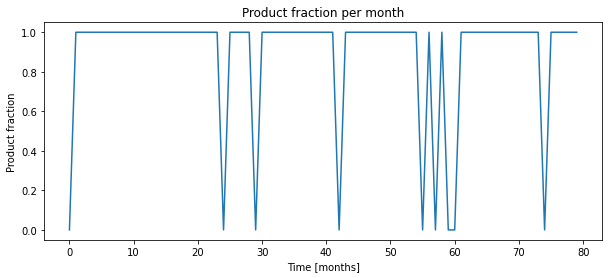

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(df['PRODUCT_FRACTION'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.ylabel('Product fraction')
plt.xlabel('Time [months]')
plt.title("Product fraction per month")
plt.show()

Split into a training and testing set. 68/12 split.

In [9]:
train = df.iloc[:50]['PRODUCT_FRACTION'].copy()
test = df.iloc[50:].copy() # Test on the last 12 months

# Format training set for TimeseriesGenerator
train = np.array([[train[i]] for i in range(len(train.to_numpy()))])

Set up a time series generator for using the last 12 values (both original and predicted values) to predict the next value.

In [10]:
n_input = 30
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

Make a **simple** LSTM.

In [11]:
model = Sequential()
model.add(LSTM(100, activation='softmax', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Train the model.

In [12]:
model.fit(generator, epochs=50)

Epoch 1/50
20/20 [==============================] - 2s 13ms/step - loss: 0.9256
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.8687
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.8148
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.7641
Epoch 5/50
20/20 [==============================] - 0s 13ms/step - loss: 0.7151
Epoch 6/50
20/20 [==============================] - 0s 13ms/step - loss: 0.6666
Epoch 7/50
20/20 [==============================] - 0s 13ms/step - loss: 0.6237
Epoch 8/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5795
Epoch 9/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5386
Epoch 10/50
20/20 [==============================] - 0s 13ms/step - loss: 0.4992
Epoch 11/50
20/20 [==============================] - 0s 13ms/step - loss: 0.4614
Epoch 12/50
20/20 [==============================] - 0s 13ms/step - loss: 0.4269
Epoch 13/50
20/20 [==================

Plot the loss per epoch.

In [13]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Predict values in the testing set.

In [14]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    
    # use the prediction to update the batch and remove the first value
    # (so the current batch is updated with the predicted value in order to predict the next value)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

Add the predicted values to the testing set.

In [15]:
test['PREDICTED_PRODUCT_FRACTION'] = test_predictions
test

DATE  PRODUCT_FRACTION  PREDICTED_PRODUCT_FRACTION
50  2019-02-01               1.0                    0.953974
51  2019-03-01               1.0                    0.952662
52  2019-04-01               1.0                    0.952961
53  2019-05-01               1.0                    0.953462
54  2019-06-01               1.0                    0.954285
55  2019-07-01               0.0                    0.957110
56  2019-08-01               1.0                    0.957522
57  2019-09-01               0.0                    0.957849
58  2019-10-01               1.0                    0.958169
59  2019-11-01               0.0                    0.958802
60  2019-12-01               0.0                    0.961544
61  2020-01-01               1.0                    0.961738
62  2020-02-01               1.0                    0.961841
63  2020-03-01               1.0                    0.961939
64  2020-04-01               1.0                    0.962041
65  2020-05-01               1.0                    0.962147
66  2020-06-01               1.0                    0.962259
67  2020-07-01               1.0                    0.962376
68  2020-08-01               1.0                    0.962498
69  2020-09-01               1.0                    0.962624
70  2020-10-01               1.0                    0.962754
71  2020-11-01               1.0                    0.962887
72  2020-12-01               1.0                    0.963352
73  2021-01-01               1.0                    0.966022
74  2021-02-01               0.0                    0.966023
75  2021-03-01               1.0                    0.965930
76  2021-04-01               1.0                    0.965830
77  2021-05-01               1.0                    0.965735
78  2021-06-01               1.0                    0.965645
79  2021-07-01               1.0                    0.965559

Plot the predicted values along with the actual values.

In [16]:
test.plot(figsize=(14,5))

<AxesSubplot:>

Calculate the root mean squared error.

In [17]:
rmse = sqrt(mean_squared_error(test['PRODUCT_FRACTION'],test['PREDICTED_PRODUCT_FRACTION']))
print(rmse)

0.39365813152060797
